<h1>Implementación del algoritmo de Shor</h1>

<h2>Imports</h2>

In [51]:
# Import numerical calculation library
import numpy as np
from numpy import pi
import sympy
from sympy import Integer, Rational, continued_fraction, mod_inverse
import math
import random
# Graphics
import matplotlib.pyplot as plt
# importing Qiskit
import qiskit
from qiskit import IBMQ, Aer
from qiskit import QuantumCircuit, assemble, transpile, execute, QuantumRegister, ClassicalRegister
print(qiskit.__qiskit_version__)
# import basic plot tools
from qiskit.visualization import plot_histogram, plot_bloch_multivector
from qiskit.tools.visualization import plot_histogram, plot_state_qsphere, plot_bloch_multivector



{'qiskit': '0.45.2', 'qiskit-aer': '0.14.2', 'qiskit-ignis': None, 'qiskit-ibmq-provider': '0.20.2', 'qiskit-nature': None, 'qiskit-finance': None, 'qiskit-optimization': None, 'qiskit-machine-learning': None}


<h2>Funciones auxiliares</h2>

In [2]:
def count_gates(qc: QuantumCircuit):
    total_gates = 0
    for qubit in qc.data:
        total_gates += 1
    return total_gates

<h2>Aritmética elemental</h2>

<h3>Sumador de N qubits</h3>

F:\ProgramFiles\Anaconda\envs\quantum_computing\lib\site-packages\qiskit\visualization\circuit\matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


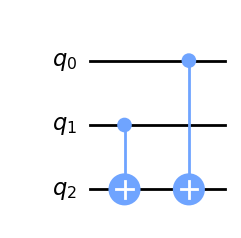

In [3]:
# Elementos basicos para la suma de N qubits
qc_carry = QuantumCircuit(4, name = "carry")
qc_carry.ccx(1,2,3)
qc_carry.cx(1,2)
qc_carry.ccx(0,2,3)

qc_carry.draw('mpl')

qc_sum = QuantumCircuit(3, name = "sum")
qc_sum.cx(1,2)
qc_sum.cx(0,2)
#print("sum: ", qc_sum)
qc_sum.draw('mpl')

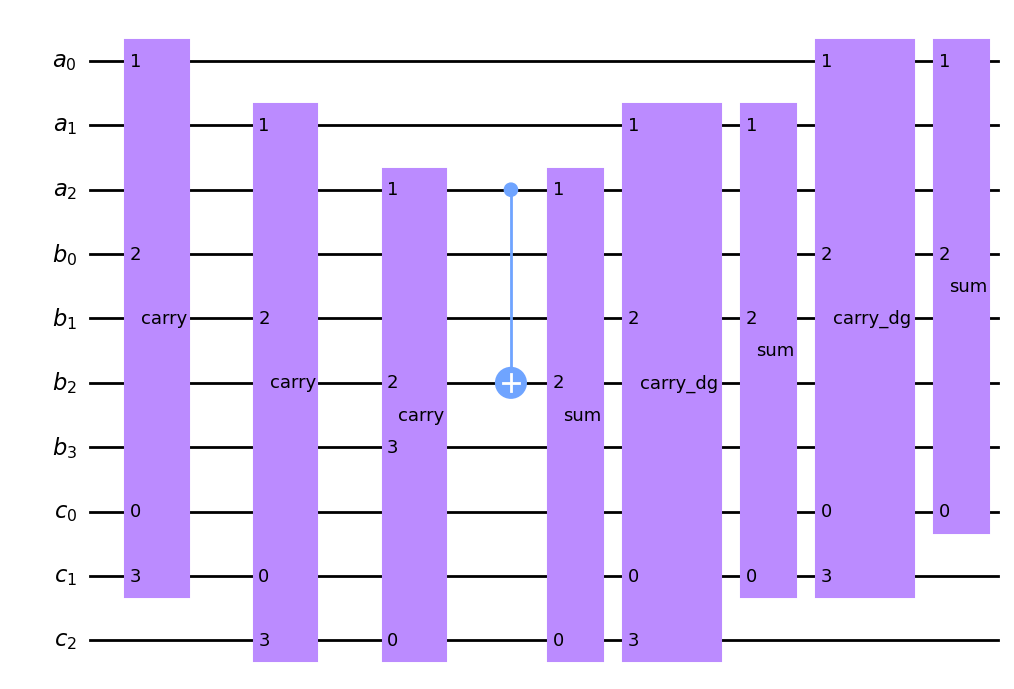

In [4]:
# Sumador de N qubits
# Entrada --> a0..an b0..bn c0..cn
# Salida --> a0..an (a+b)0..(a+b)n+1 c1..cn
def createAdder(n):
    qr_a = QuantumRegister(n,'a')
    qr_b = QuantumRegister(n+1,'b')
    qr_c = QuantumRegister(n,'c')
    qc_carry_dg = qc_carry.inverse()
    qc_adder = QuantumCircuit(qr_a, qr_b, qr_c, name = "adder-"+str(n))
    for i in range(n-1):
        qc_adder.append(qc_carry, [2*n+1+i, i, n+i, 2*n+1+i+1])
    qc_adder.append(qc_carry, [3*n, n-1, 2*n-1, 2*n])
    
    qc_adder.cx(n-1, 2*n-1)
    qc_adder.append(qc_sum, [3*n, n-1, 2*n-1])
    
    for i in range(n-2,-1,-1):
        qc_adder.append(qc_carry_dg, [2*n+1+i, i, n+i, 2*n+1+i+1])
        qc_adder.append(qc_sum, [2*n+1+i, i, n+i])
        
    return qc_adder
    
qc_adder = createAdder(3)
qc_adder.draw('mpl')

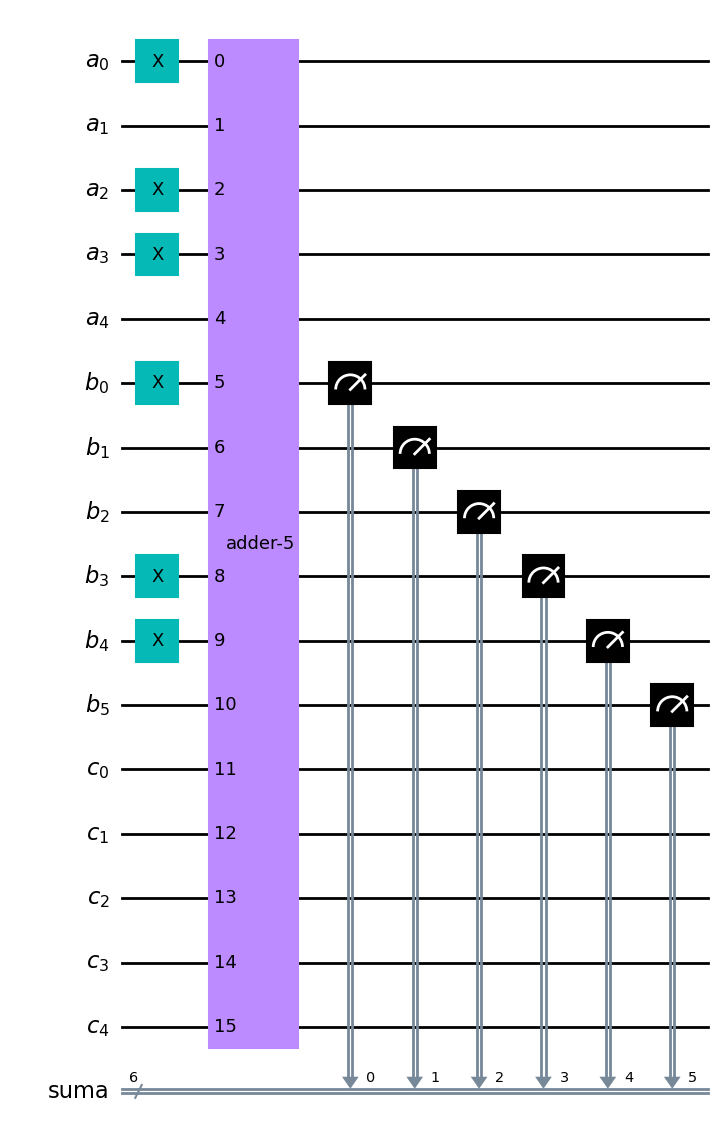

In [5]:
# Prueba del sumador de N qubits
n = 5
qr_a = QuantumRegister(n,'a')
qr_b = QuantumRegister(n+1,'b')
qr_c = QuantumRegister(n,'c')
cr = ClassicalRegister(n+1, 'suma')
qc_suma = QuantumCircuit(qr_a, qr_b, qr_c,cr)
# A = 01101 = 13
qc_suma.x(0)
qc_suma.x(2)
qc_suma.x(3)
# B = 11001 = 25
qc_suma.x(n)
qc_suma.x(n+3)
qc_suma.x(n+4)

qc_suma.append(createAdder(n), range(3*n+1))
for i in range(n+1):
    qc_suma.measure(n+i,i)
# Resultado esperado = A + B = 13 + 25 = 38 = 100110
qc_suma.draw('mpl')

Result(backend_name='aer_simulator', backend_version='0.14.2', qobj_id='', job_id='04d6d2bc-5f98-4f8a-baad-073a56920f16', success=True, results=[ExperimentResult(shots=1024, success=True, meas_level=2, data=ExperimentResultData(counts={'0x26': 1024}), header=QobjExperimentHeader(creg_sizes=[['suma', 6]], global_phase=0.0, memory_slots=6, n_qubits=16, name='circuit-178', qreg_sizes=[['a', 5], ['b', 6], ['c', 5]], metadata={}), status=DONE, seed_simulator=1630584997, metadata={'batched_shots_optimization': False, 'required_memory_mb': 1, 'method': 'statevector', 'active_input_qubits': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15], 'device': 'CPU', 'remapped_qubits': False, 'num_qubits': 16, 'num_clbits': 6, 'time_taken': 0.0294892, 'sample_measure_time': 0.000229, 'input_qubit_map': [[0, 0], [1, 1], [2, 2], [3, 3], [4, 4], [5, 5], [6, 6], [7, 7], [8, 8], [9, 9], [10, 10], [11, 11], [12, 12], [13, 13], [14, 14], [15, 15]], 'max_memory_mb': 8134, 'measure_sampling': True, 'noise':

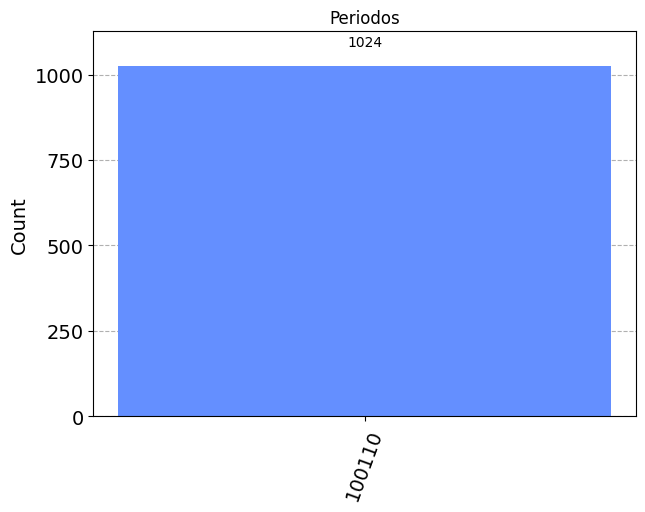

In [6]:
# Ejecutamos el circuito en un simulador cuántico
#simulator = Aer.get_backend('aer_simulator')
simulator = Aer.get_backend('aer_simulator', method = 'statevector', device = 'gpu')
qc_suma_transpiled = transpile(qc_suma, simulator)

# Run and get counts
result = simulator.run(qc_suma_transpiled).result()
print(result)
counts = result.get_counts(qc_suma_transpiled)
plot_histogram(counts, title='Periodos')

<h3>Sumador modular</h3>

Sumador modular - Versión inspirada por V. Vedral, A. Barenco y A. Ekert.

Limitación: solo funciona si 2*M > a + b, es decir, M debe tener por lo menos n cifras significativas para funcionar para cualquier valor de a y b.

F:\ProgramFiles\Anaconda\envs\quantum_computing\lib\site-packages\qiskit\visualization\circuit\matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


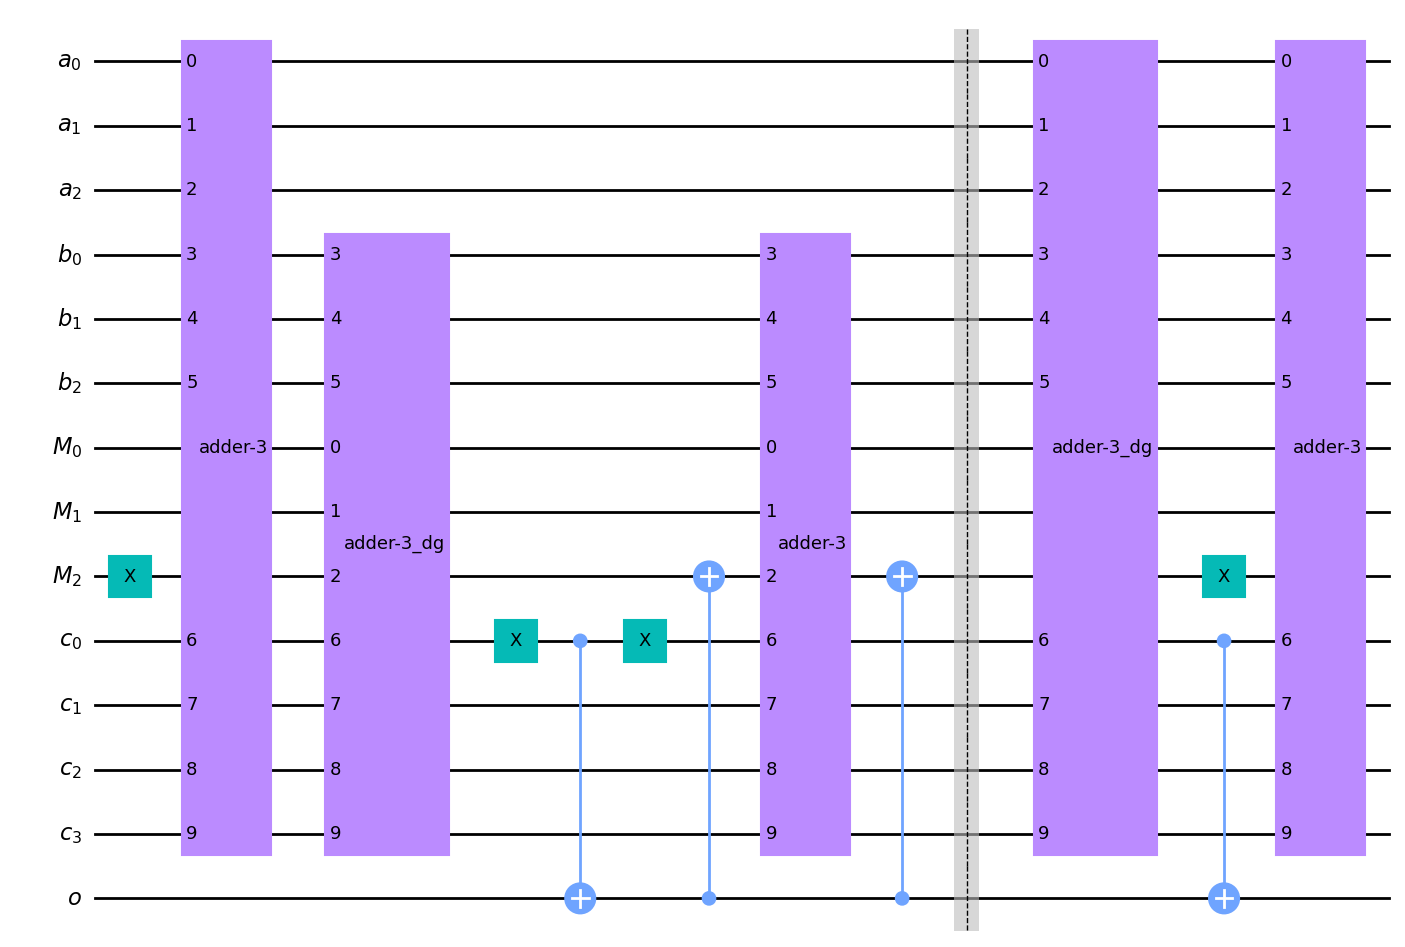

In [7]:
# Sumador de N qubits modulo M
# Entrada --> a[0]..an b[0]..bn aux[0]..aux[2*n+2]
# Salida --> a[0]..an [(a+b) mod M][0]..[(a+b) mod M][n] aux[0]..aux[2*n+2]
def createModAdderVedral(n, M):
    qr_a = QuantumRegister(n,'a')
    qr_b = QuantumRegister(n,'b')
    qr_m = QuantumRegister(n,'M')
    qr_c = QuantumRegister(n+1,'c')
    qr_o = QuantumRegister(1,'o')
    
    # Circuitos que usaremos
    qc_adder = createAdder(n)
    qc_subtractor = qc_adder.inverse()

    # Creamos el circuito
    qc_mod_adder = QuantumCircuit(qr_a, qr_b, qr_m, qr_c, qr_o, name = "adder-"+str(n)+" mod "+str(M))

    # Inicializamos M
    m = M
    for i in range(n):
        if m % 2 == 1:
            qc_mod_adder.x(2*n+i)
        m = m // 2
    
    # Sumamos a y b (resultado --> [n-2n, 3*n+1])
    qc_mod_adder.append(qc_adder, list(range(2*n)) + list(range(3*n,4*n+1)))

    # Restamos al resultado M
    qc_mod_adder.append(qc_subtractor, list(range(2*n, 3*n)) + list(range(n, 2*n))+ list(range(3*n,4*n+1)))

    # Guardamos el overflow
    qc_mod_adder.x(3*n)
    qc_mod_adder.cx(3*n,4*n+1)
    qc_mod_adder.x(3*n)

    # Limpiamos el registro M si hay overflow
    m = M
    for i in range(n):
        if m % 2 == 1:
            qc_mod_adder.cx(4*n+1, 2*n+i)
        m = m // 2

    # Sumamos al resultado el registro M
    qc_mod_adder.append(qc_adder, list(range(2*n, 3*n)) + list(range(n, 2*n))+ list(range(3*n,4*n+1)))

    # Recuperamos el registro M
    m = M
    for i in range(n):
        if m % 2 == 1:
            qc_mod_adder.cx(4*n+1, 2*n+i)
        m = m // 2
    qc_mod_adder.barrier()
    # Deshacemos la suma inicial para obtener el valor del acarreo
    qc_mod_adder.append(qc_subtractor, list(range(2*n)) + list(range(3*n,4*n+1)))
    
    qc_mod_adder.cx(3*n,4*n+1)

    # Realizamos finalmente la suma
    qc_mod_adder.append(qc_adder, list(range(2*n)) + list(range(3*n,4*n+1)))

    # Deshacemos M
    m = M
    for i in range(n):
        if m % 2 == 1:
            qc_mod_adder.x(2*n+i)
        m = m // 2
        
    return qc_mod_adder
    
createModAdderVedral(3, 20).draw('mpl')

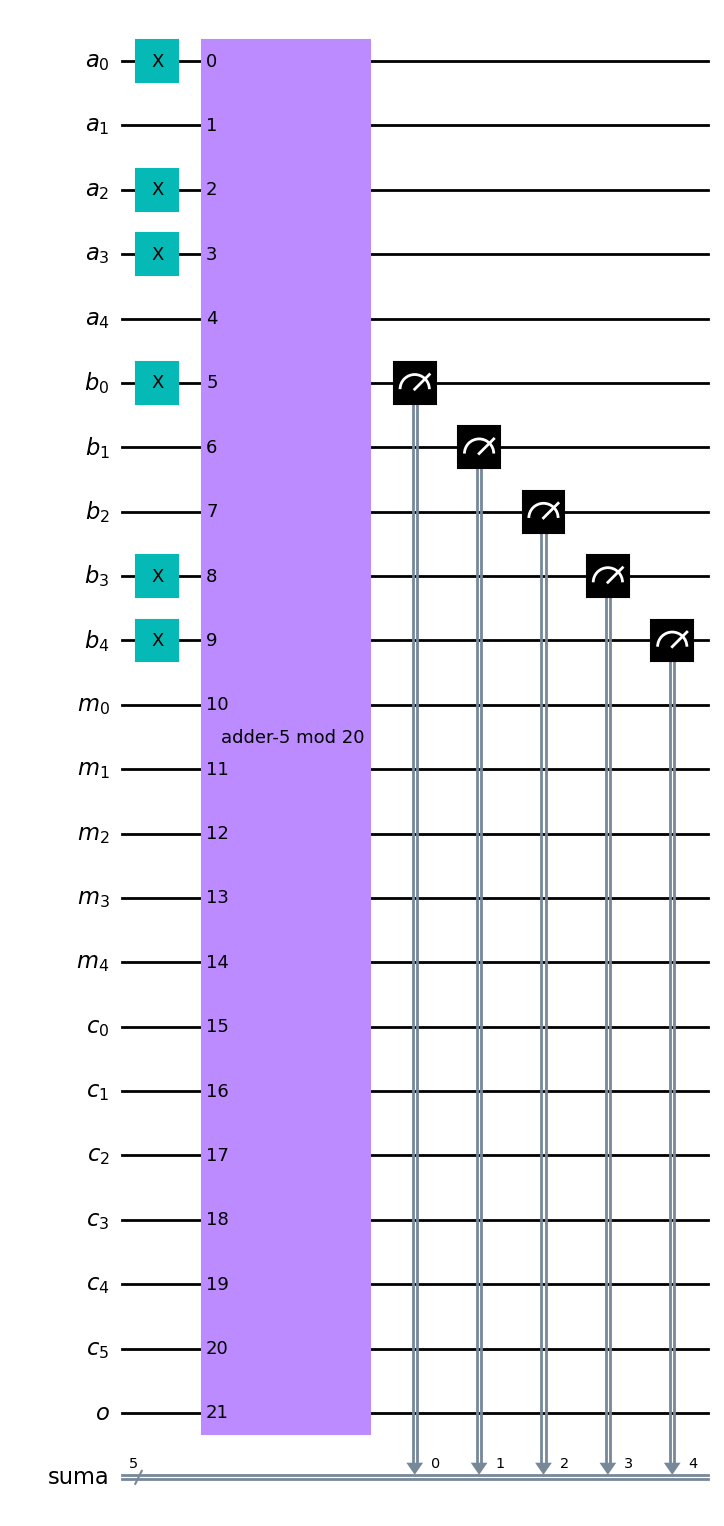

In [8]:
# Prueba del sumador de N qubits
n = 5
qr_a = QuantumRegister(n,'a')
qr_b = QuantumRegister(n,'b')
qr_m = QuantumRegister(n,'m')
qr_c = QuantumRegister(n+1,'c')
qr_o = QuantumRegister(1,'o')
cr = ClassicalRegister(n, 'suma')
qc_suma_mod = QuantumCircuit(qr_a, qr_b, qr_m, qr_c, qr_o, cr)
# A = 01101 = 13
qc_suma_mod.x(0)
qc_suma_mod.x(2)
qc_suma_mod.x(3)
# B = 11001 = 25
qc_suma_mod.x(5)
qc_suma_mod.x(8)
qc_suma_mod.x(9)
qc_suma_mod.append(createModAdderVedral(n, 20),range(4*n+2))

for i in range(n):
    qc_suma_mod.measure(n+i,i)
# Resultado esperado = A + B = 13 + 25 mod 10 = 8 = 1000
qc_suma_mod.draw('mpl')

Result(backend_name='aer_simulator', backend_version='0.14.2', qobj_id='', job_id='6c14449f-f8cb-4421-afbf-7bbc6ec5adc4', success=True, results=[ExperimentResult(shots=1024, success=True, meas_level=2, data=ExperimentResultData(counts={'0x12': 1024}), header=QobjExperimentHeader(creg_sizes=[['suma', 5]], global_phase=0.0, memory_slots=5, n_qubits=22, name='circuit-242', qreg_sizes=[['a', 5], ['b', 5], ['m', 5], ['c', 6], ['o', 1]], metadata={}), status=DONE, seed_simulator=2620839518, metadata={'batched_shots_optimization': False, 'required_memory_mb': 64, 'method': 'statevector', 'active_input_qubits': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21], 'device': 'CPU', 'remapped_qubits': False, 'num_qubits': 22, 'num_clbits': 5, 'time_taken': 0.7130142, 'sample_measure_time': 0.0067419, 'input_qubit_map': [[0, 0], [1, 1], [2, 2], [3, 3], [4, 4], [5, 5], [6, 6], [7, 7], [8, 8], [9, 9], [10, 10], [11, 11], [12, 12], [13, 13], [14, 14], [15, 15], [16, 16], [1

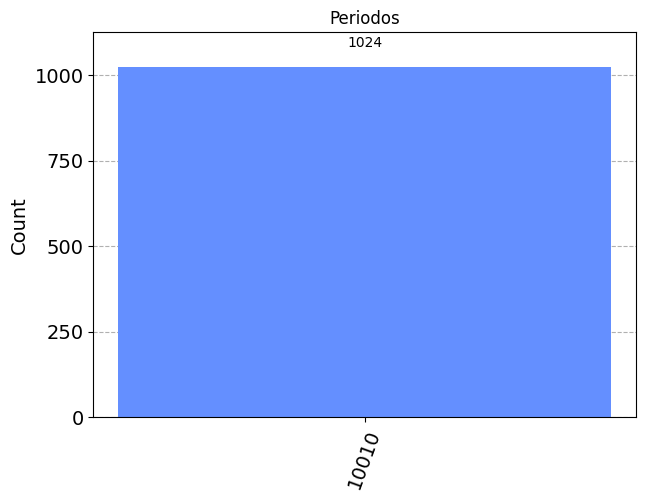

In [9]:
# Ejecutamos el circuito en un simulador cuántico
simulator = Aer.get_backend('aer_simulator', method = 'statevector', device = 'gpu')
qc_suma_mod_transpiled = transpile(qc_suma_mod, simulator)

# Run and get counts
result = simulator.run(qc_suma_mod_transpiled).result()
print(result)
counts = result.get_counts(qc_suma_mod_transpiled)
plot_histogram(counts, title='Periodos')

<h2>Multiplicacion modular controlada</h2>

F:\ProgramFiles\Anaconda\envs\quantum_computing\lib\site-packages\qiskit\visualization\circuit\matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


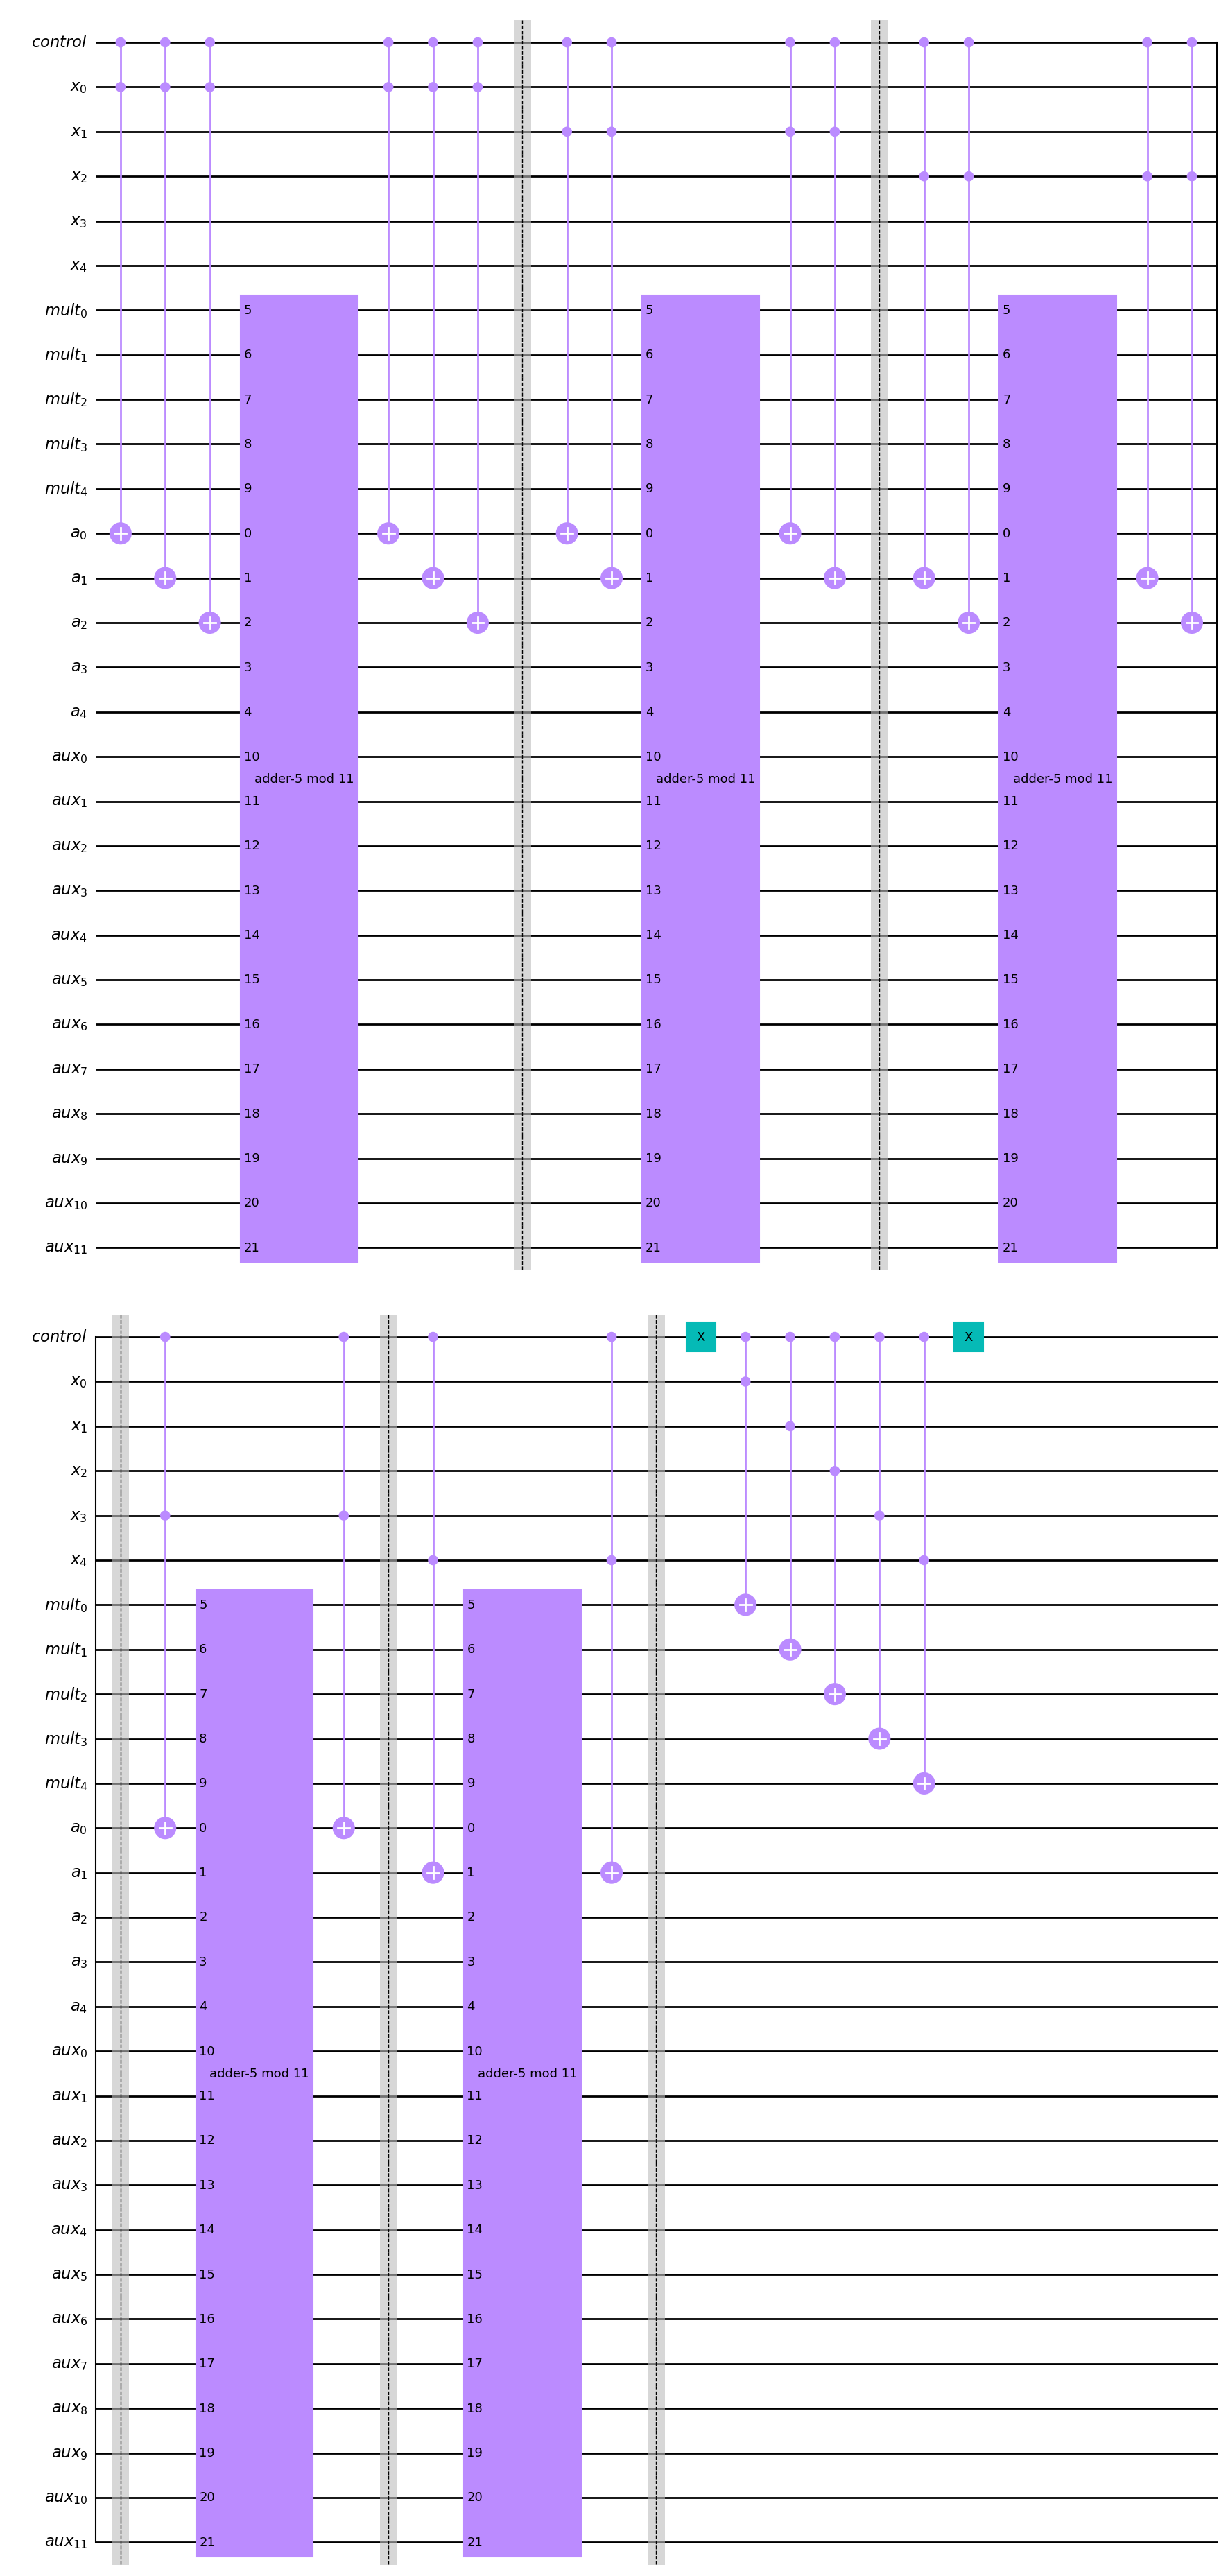

In [10]:
# Multiplicacion de N qubits modulo M
# Entrada --> control x[0]..x[n] 0[0]..0[n] aux[0]..auxn[3*n+2]
# Salida -->  control x[0]..x[n] (x*y)[0]..(x*y)[n] aux[0]..auxn[2*n+2]

def createMult(n, y, M):
    qr_c = QuantumRegister(1,'control')
    qr_x = QuantumRegister(n,'x')
    qr_mult = QuantumRegister(n,'mult')
    qr_a = QuantumRegister(n,'a')
    qr_aux = QuantumRegister(2*n+2,'aux')
    
    # Subcircuitos que usaremos
    qc_mod_adder = createModAdderVedral(n, M)

    # Creamos el circuito
    qc_mod_mult = QuantumCircuit(qr_c, qr_x, qr_mult, qr_a, qr_aux, name = "x"+str(y)+" mod "+str(M)+"-"+str(n))

    y_act = y

    # Por cada qubit del multiplicador
    for i in range(n):
        # Si el qubit x[i] es 1 --> Sumamos 2^i*y mod M
        # Si no, sumamos 0
        # Colocamos en el registro 2^i*y o 0
        m = y_act
        for j in range(n):
            if m % 2 == 1:
                qc_mod_mult.ccx(0,i+1,2*n+1+j)
            m = m // 2

        # Realizamos la suma modular
        qc_mod_mult.append(qc_mod_adder, list(range(2*n+1, 3*n+1)) + list(range(n+1, 2*n+1)) + list(range(3*n+1,5*n+3)))
        
        # Borramos el contenido de a
        m = y_act
        for j in range(n):
            if m % 2 == 1:
                qc_mod_mult.ccx(0,i+1,2*n+1+j)
            m = m // 2
        
        # Calculamos el siguiente 2^i*y mod M
        #print(y_act)
        y_act = 2*y_act % M
        qc_mod_mult.barrier()

    # Finalmente, si detectamos que el qubit de control esta desactivado
    # Copiamos x en el resultado
    qc_mod_mult.x(0)
    for i in range(n):
        qc_mod_mult.ccx(0,i+1,n+i+1)
    qc_mod_mult.x(0)
    
    return qc_mod_mult

qc_mult = createMult(n, 7, 11)
qc_mult.draw('mpl')

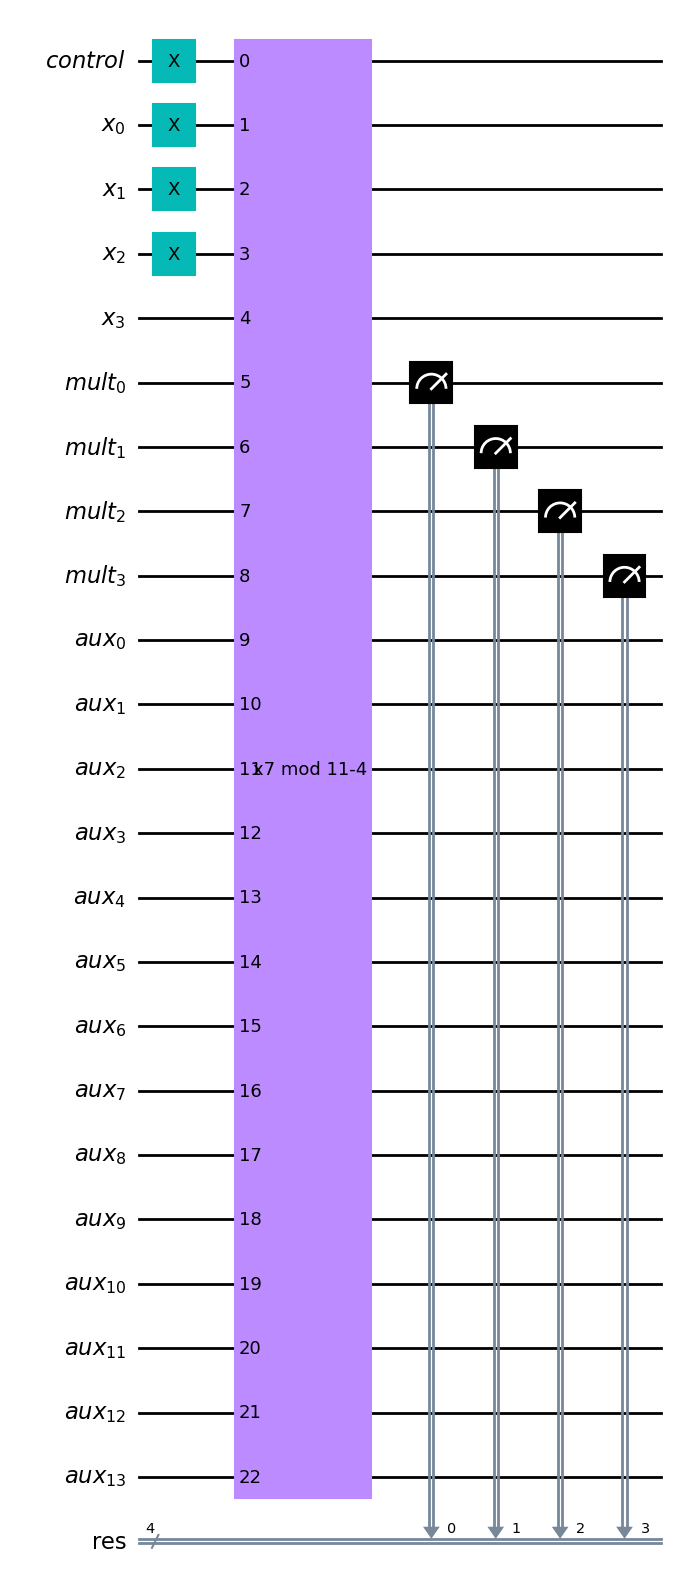

In [11]:
# Prueba del multiplicador de N qubits mod M
n = 4
qr_c = QuantumRegister(1,'control')
qr_x = QuantumRegister(n,'x')
qr_mult = QuantumRegister(n,'mult')
qr_aux = QuantumRegister(3*n+2,'aux')
cr = ClassicalRegister(n, 'res')
qc_prueba_mod_mult = QuantumCircuit(qr_c, qr_x, qr_mult, qr_aux, cr)

# Activamos el qubit de control
#qc_prueba_mod_mult.x(0)
qc_prueba_mod_mult.x(0)

# X = 0111 = 7
qc_prueba_mod_mult.x(1)
qc_prueba_mod_mult.x(2)
qc_prueba_mod_mult.x(3)

qc_prueba_mod_mult.append(createMult(n, 7, 11), range(5*n+3))

for i in range(n):
    qc_prueba_mod_mult.measure(n+1+i,i)
# Resultado esperado = 7*7 mod 11 = 49 mod 11 = 5
qc_prueba_mod_mult.draw('mpl')

Result(backend_name='aer_simulator', backend_version='0.14.2', qobj_id='', job_id='d7bdf8a8-5542-49a7-bb7d-0fbffda4c4e3', success=True, results=[ExperimentResult(shots=1, success=True, meas_level=2, data=ExperimentResultData(counts={'0x5': 1}), header=QobjExperimentHeader(creg_sizes=[['res', 4]], global_phase=0.0, memory_slots=4, n_qubits=23, name='circuit-341', qreg_sizes=[['control', 1], ['x', 4], ['mult', 4], ['aux', 14]], metadata={}), status=DONE, seed_simulator=851897499, metadata={'batched_shots_optimization': False, 'required_memory_mb': 128, 'method': 'statevector', 'active_input_qubits': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22], 'device': 'CPU', 'remapped_qubits': False, 'num_qubits': 23, 'num_clbits': 4, 'time_taken': 4.7489688, 'sample_measure_time': 0.0150157, 'input_qubit_map': [[0, 0], [1, 1], [2, 2], [3, 3], [4, 4], [5, 5], [6, 6], [7, 7], [8, 8], [9, 9], [10, 10], [11, 11], [12, 12], [13, 13], [14, 14], [15, 15], [16, 16], [17,

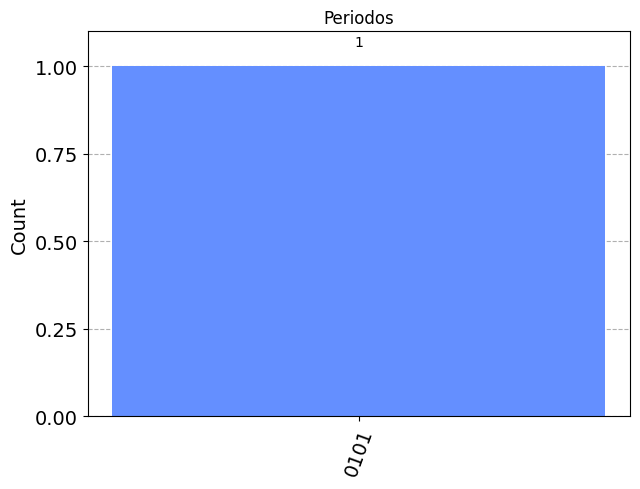

In [12]:
# Ejecutamos el circuito en un simulador cuántico
simulator = Aer.get_backend('aer_simulator', method = 'statevector', device = 'gpu')
qc_prueba_mod_mult_transpiled = transpile(qc_prueba_mod_mult, simulator)

# Run and get counts
result = simulator.run(qc_prueba_mod_mult_transpiled, shots=1).result()
print(result)
counts = result.get_counts(qc_prueba_mod_mult_transpiled)
plot_histogram(counts, title='Periodos')

<h2>Exponenciación modular</h2>

F:\ProgramFiles\Anaconda\envs\quantum_computing\lib\site-packages\qiskit\visualization\circuit\matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


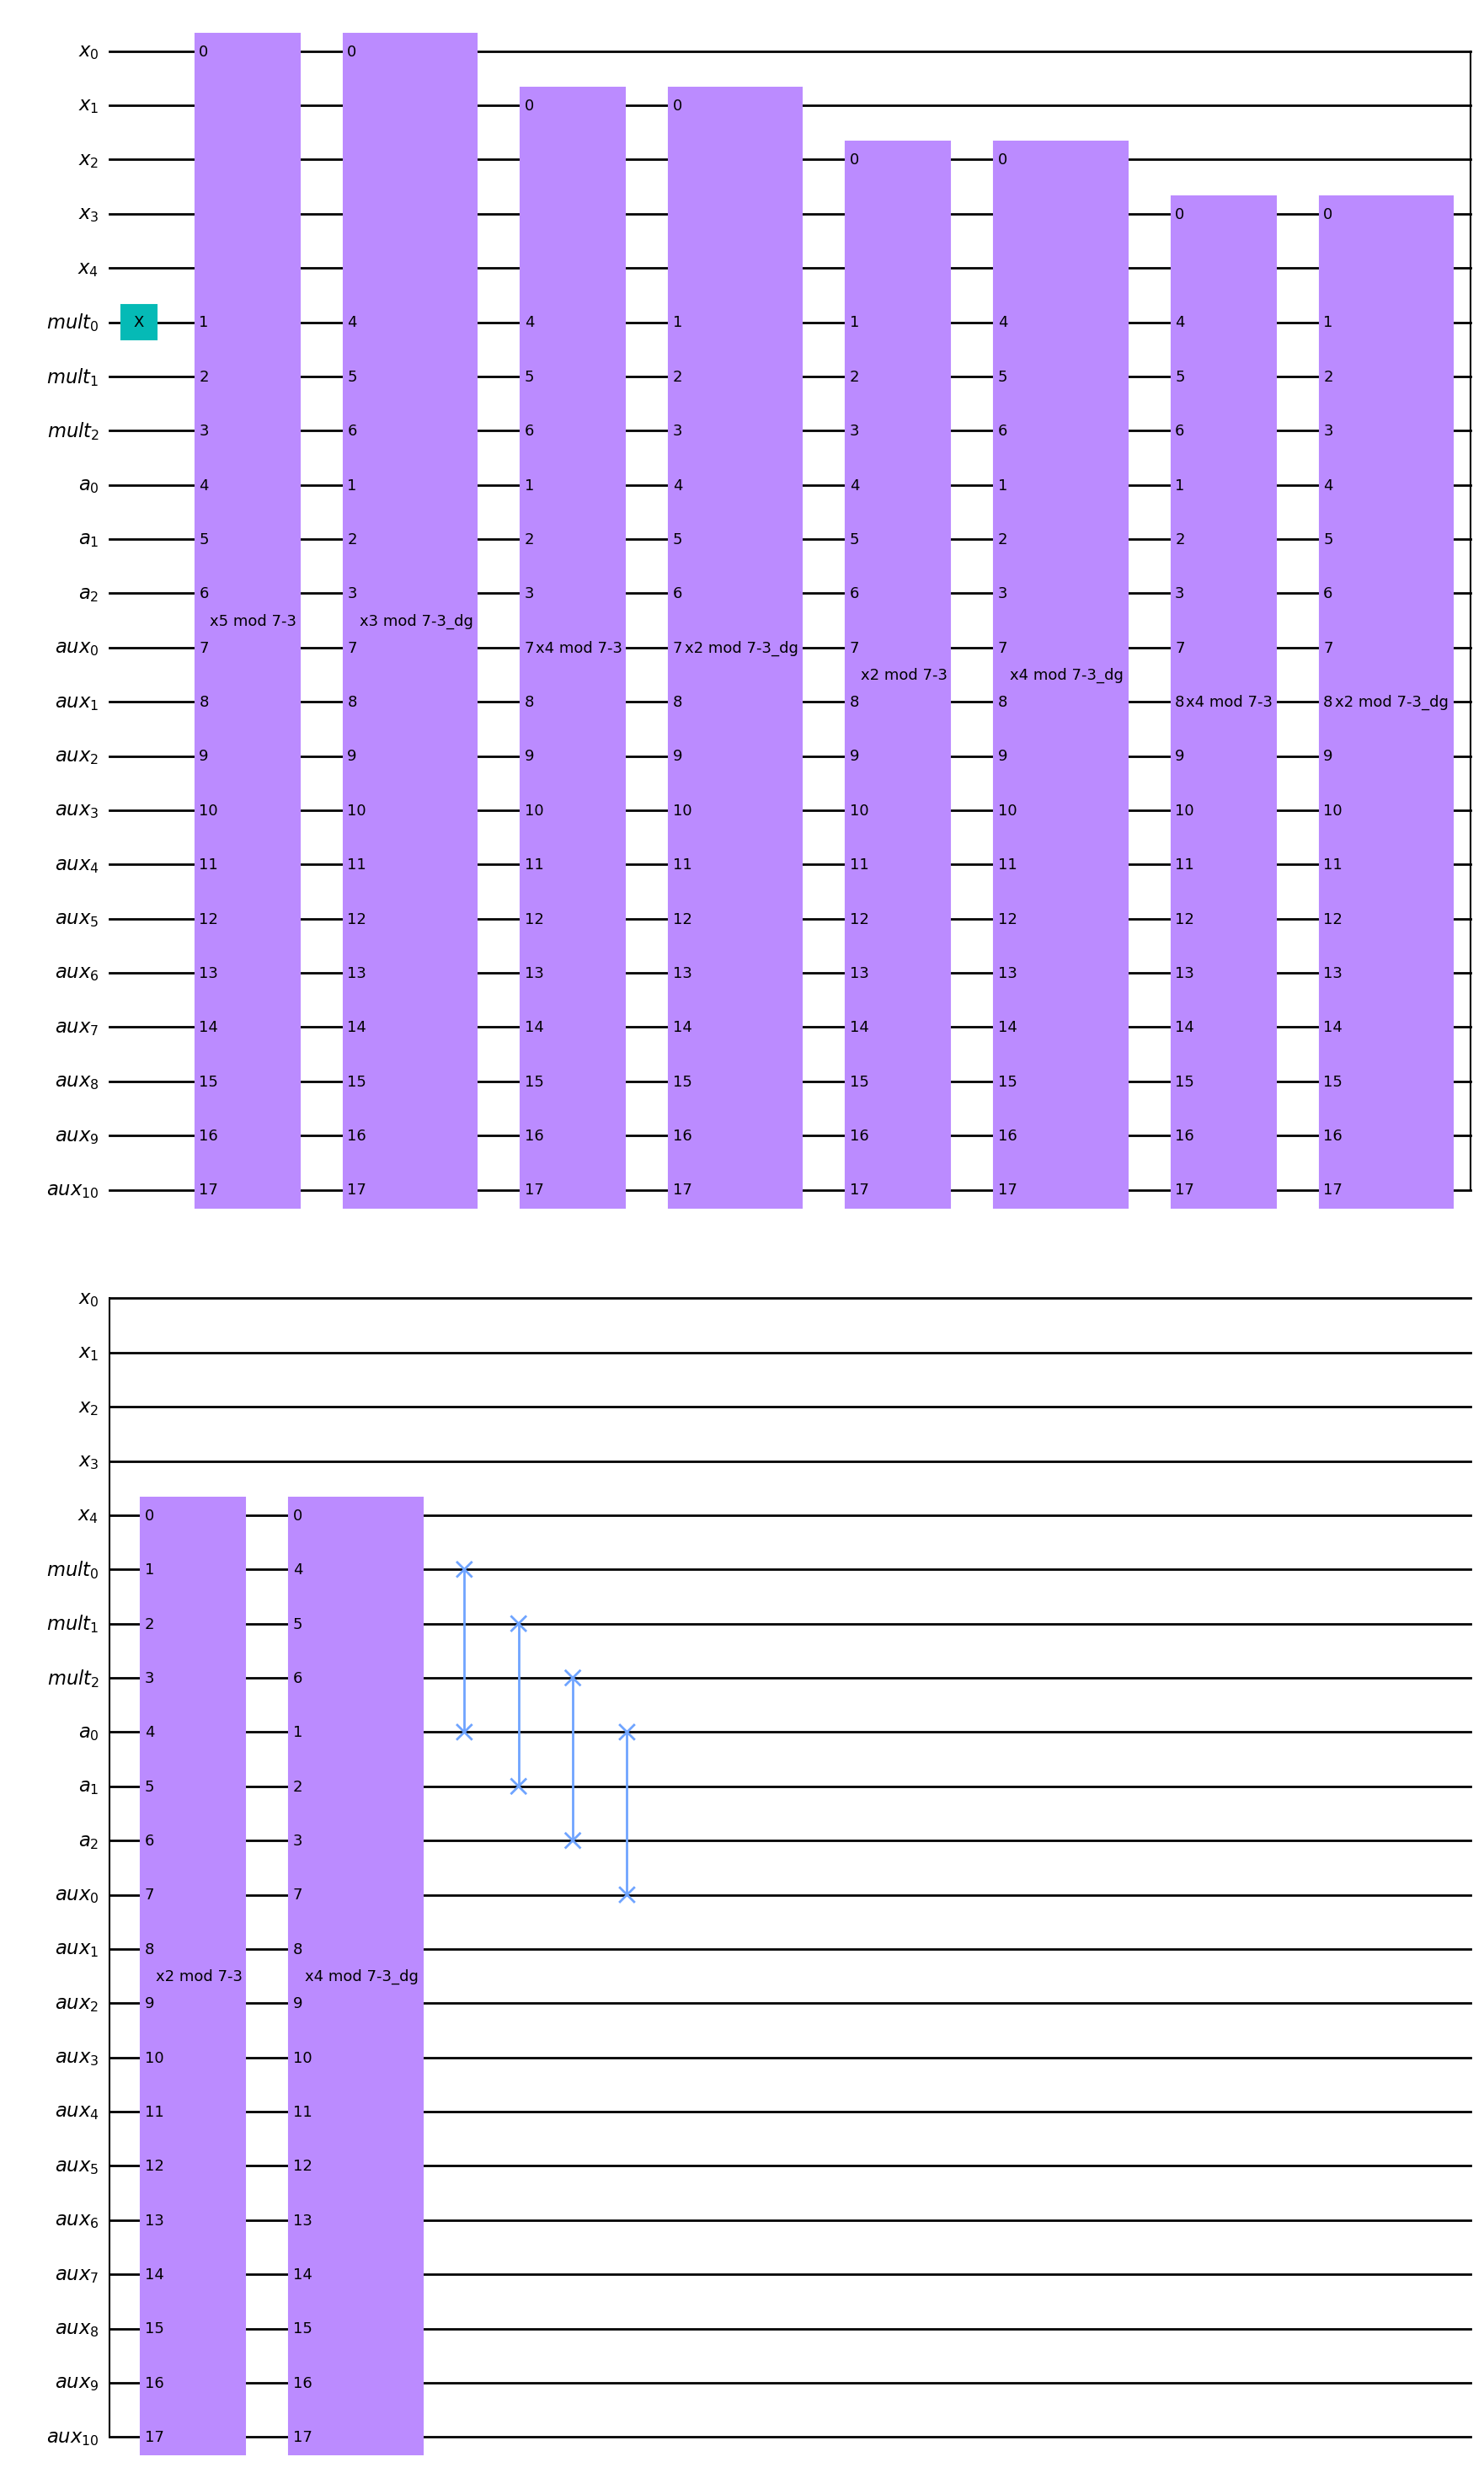

In [13]:
##### Exponenciacion modular rapida
# Entrada --> exp[0..n_in] 0[0..n_out] aux[0..4*n_out+2]
# Salida -->  exp[0..n_in] (y^exp mod M)[0..n_out] aux[0..4*n+2]


def createExpMod(n_in, n_out, y, M):
    qr_x = QuantumRegister(n_in,'x')
    qr_mult = QuantumRegister(n_out,'mult')
    qr_a = QuantumRegister(n_out,'a')
    qr_aux = QuantumRegister(3*n_out+2,'aux')
    
    # Creamos el circuito
    qc_exp_mod = QuantumCircuit(qr_x, qr_mult, qr_a, qr_aux, name = str(y)+"^a mod "+str(M)+"-"+str(n))
    # Inicializamos a = 1
    qc_exp_mod.x(n_in)
    
    mult_actual = y
    for i in range(0, n_in-1, 2):
        subcircuit = createMult(n_out, mult_actual, M)
        qc_exp_mod.append(subcircuit, [i]+list(range(n_in,n_in+5*n_out+2)))
        subcircuit = createMult(n_out,mod_inverse(mult_actual, M), M)
        qc_exp_mod.append(subcircuit.inverse(), [i]+list(range(n_in+n_out,n_in+2*n_out))+list(range(n_in,n_in+n_out))+list(range(n_in+2*n_out,n_in+5*n_out+2)))
        mult_actual = (mult_actual * mult_actual) % M
        
        subcircuit = createMult(n_out, mult_actual, M)
        qc_exp_mod.append(subcircuit, [i+1]+list(range(n_in+n_out,n_in+2*n_out))+list(range(n_in, n_in+n_out))+list(range(n_in+2*n_out,n_in+5*n_out+2)))
        subcircuit = createMult(n_out,mod_inverse(mult_actual, M), M)
        qc_exp_mod.append(subcircuit.inverse(), [i+1]+list(range(n_in,n_in+5*n_out+2)))
        mult_actual = (mult_actual * mult_actual) % M
    
    if n_in % 2 == 1:
        subcircuit = createMult(n_out, mult_actual, M)
        qc_exp_mod.append(subcircuit, [n_in-1]+list(range(n_in,n_in+5*n_out+2)))
        subcircuit = createMult(n_out,mod_inverse(mult_actual, M), M)
        qc_exp_mod.append(subcircuit.inverse(), [n_in-1]+list(range(n_in+n_out,n_in+2*n_out))+list(range(n_in,n_in+n_out))+list(range(n_in+2*n_out,n_in+5*n_out+2)))
        for j in range(n):
            qc_exp_mod.swap(n_in+j,n_in+n_out+j)
   

    return qc_exp_mod
qc_exp_mod = createExpMod(5, 3, 5, 7)
qc_exp_mod.draw('mpl')

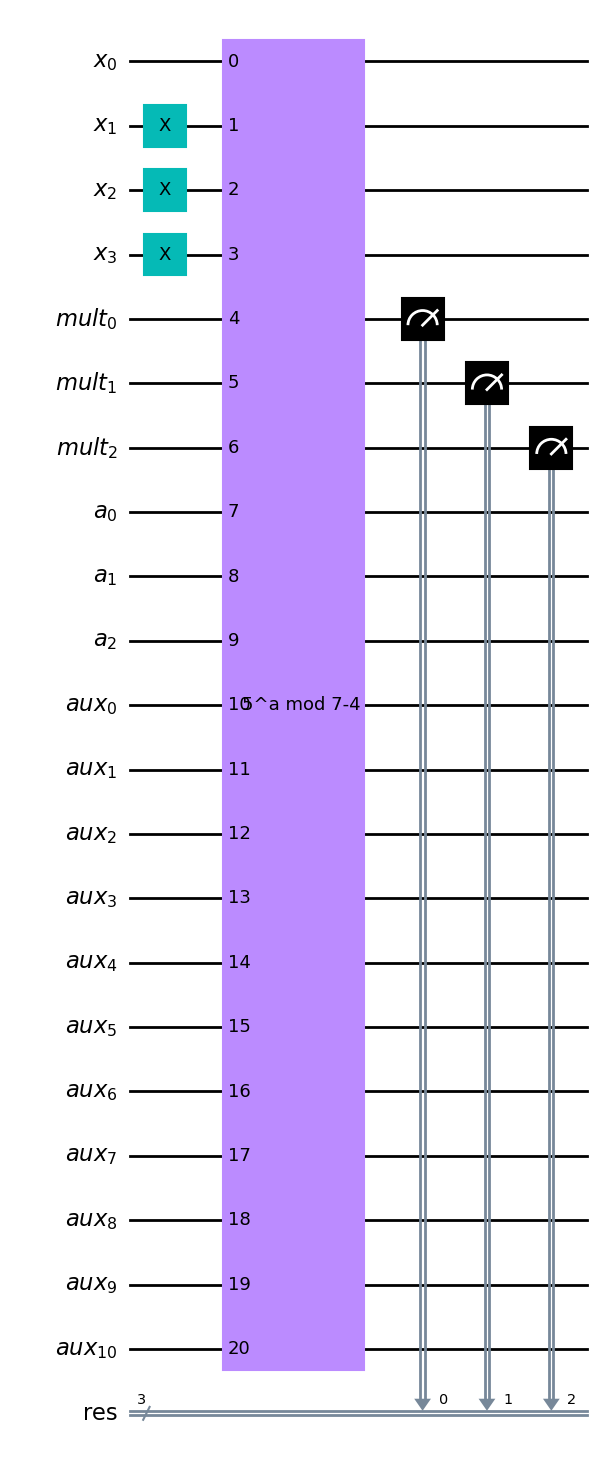

In [14]:
# Prueba de la exponenciacion de N qubits mod M
n_in = 4
n_out = 3
qr_x = QuantumRegister(n_in,'x')
qr_mult = QuantumRegister(n_out,'mult')
qr_a = QuantumRegister(n_out,'a')
qr_aux = QuantumRegister(3*n_out+2,'aux')
cr = ClassicalRegister(n_out, 'res')
qc_prueba_exp_mod = QuantumCircuit(qr_x, qr_mult, qr_a, qr_aux, cr)
# Activamos el qubit de control
#qc_prueba_mod_mult.x(0)

# X = 1110 = 14
#qc_prueba_exp_mod.x(0)
qc_prueba_exp_mod.x(1)
qc_prueba_exp_mod.x(2)
qc_prueba_exp_mod.x(3)

qc_prueba_exp_mod.append(createExpMod(n_in, n_out, 5, 7), range(n_in+5*n_out+2))

for i in range(n_out):
    qc_prueba_exp_mod.measure(n_in+i,i)
    
# Resultado esperado = 5^5 mod 7 = 3 mod 7
qc_prueba_exp_mod.draw('mpl')

Result(backend_name='aer_simulator', backend_version='0.14.2', qobj_id='', job_id='ab5cd2d6-791f-49a9-8804-d080f195f448', success=True, results=[ExperimentResult(shots=1024, success=True, meas_level=2, data=ExperimentResultData(counts={'0x4': 1024}), header=QobjExperimentHeader(creg_sizes=[['res', 3]], global_phase=0.0, memory_slots=3, n_qubits=21, name='circuit-786', qreg_sizes=[['x', 4], ['mult', 3], ['a', 3], ['aux', 11]], metadata={}), status=DONE, seed_simulator=1519922944, metadata={'batched_shots_optimization': False, 'required_memory_mb': 32, 'method': 'statevector', 'active_input_qubits': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20], 'device': 'CPU', 'remapped_qubits': False, 'num_qubits': 21, 'num_clbits': 3, 'time_taken': 4.9044178, 'sample_measure_time': 0.0037552, 'input_qubit_map': [[0, 0], [1, 1], [2, 2], [3, 3], [4, 4], [5, 5], [6, 6], [7, 7], [8, 8], [9, 9], [10, 10], [11, 11], [12, 12], [13, 13], [14, 14], [15, 15], [16, 16], [17, 17], [1

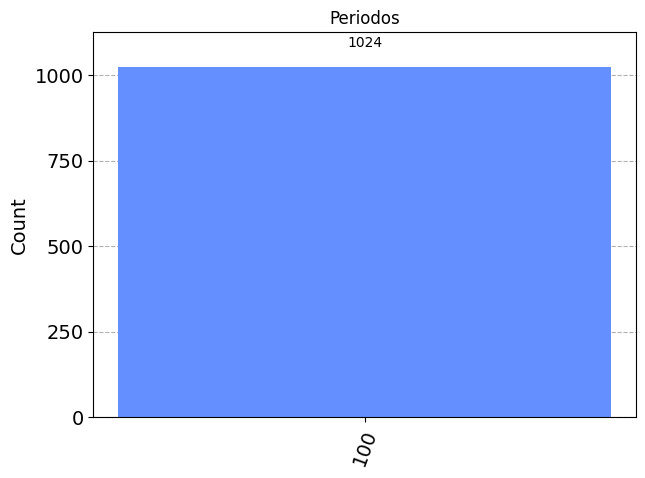

In [15]:
# Ejecutamos el circuito en un simulador cuántico
simulator = Aer.get_backend('aer_simulator', method = 'statevector', device = 'gpu')
qc_exp_mod_transpiled = transpile(qc_prueba_exp_mod, simulator)

# Run and get counts
result = simulator.run(qc_exp_mod_transpiled, shots=1024).result()
print(result)
counts = result.get_counts(qc_exp_mod_transpiled)
plot_histogram(counts, title='Periodos')

<h2>Quantum Fourier Transform</h2>

In [16]:
# Definimos la puerta Rz-contralada como 4 puertas básicas
# Referencias: Página 181 Nielsen-Chuang
#def c_rz(circuit, theta, control_qubit, target_qubit):
#    circuit.rz(theta/2, target_qubit)
#    circuit.cx(control_qubit, target_qubit)
#    circuit.rz(-theta/2, target_qubit)
#    circuit.cx(control_qubit, target_qubit)

# Alternativamente, podemos crear una puerta controlada con el metodo control()
def createCRzGate(theta, name):
    qc1 = QuantumCircuit(1, name = name)
    qc1.rz(theta, 0)
    custom = qc1.to_gate().control(1)
    return custom

qc2 = QuantumCircuit(4)
qc2.append(createCRzGate(np.pi, "crz"), [0, 1])
print(qc2)

            
q_0: ───■───
     ┌──┴──┐
q_1: ┤ crz ├
     └─────┘
q_2: ───────
            
q_3: ───────
            


Transformada Cuántica de Fourier:


F:\ProgramFiles\Anaconda\envs\quantum_computing\lib\site-packages\qiskit\visualization\circuit\matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


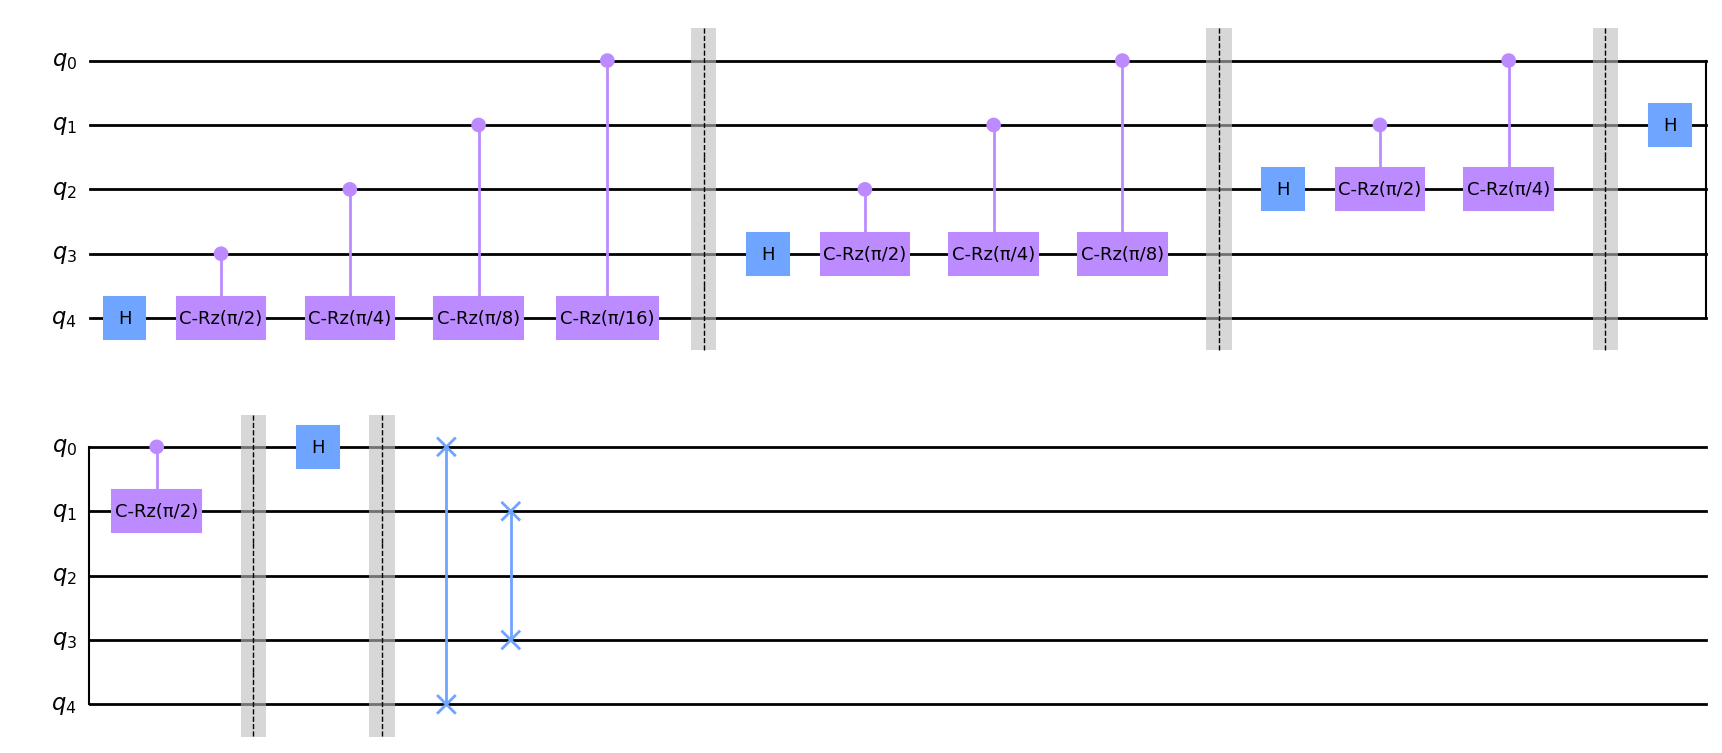

In [17]:
def QFT(n):
    # Creamos un circuito cuántico principal con N qubits
    qft = QuantumCircuit(n, name = 'QFT')
    
    # Creamos las puertas Rz-controladas
    qc_rzs = []
    for i in range(n):
        nombre = 'C-Rz(π/'+str(2**(i+1))+')'
        qc_rzs.append(createCRzGate(np.pi/(2**(i+1)), nombre))
    
    # Calculamos la QFT de cada qubit
    for i in range(n-1,-1,-1):
        qft.h(i)
        for j in range(i):
            qft.append(qc_rzs[j], [i-j-1,i])
        qft.barrier()
    
    # Intercambiamos de posicion los qubits
    for i in range(n//2):
        qft.swap(i, n-i-1)

    return qft
print("Transformada Cuántica de Fourier:")
QFT(5).draw('mpl')

<h2>Busqueda del periodo de una funcion</h2>

<h3>Busqueda de periodo potencia de 2</h3>

In [18]:
import itertools

In [19]:
# Busqueda del periodo de una funcion
# Creamos un circuito cuántico principal con N qubits
def busqueda_periodo_potencia2(num, base):
    n = math.ceil(math.log2(num))
    qr_x = QuantumRegister(n,'x')
    qr_mult = QuantumRegister(n,'mult')
    qr_aux = QuantumRegister(4*n+2,'aux')
    cr = ClassicalRegister(n)
    find_period = QuantumCircuit(qr_x, qr_mult, qr_aux, cr, name = 'Find_period')
    
    # Superposicion de las entradas
    for i in range(n):
        find_period.h(i)
    
    find_period.barrier()
    
    # Aplicamos una funcion periodica
    find_period.append(createExpMod(n, n, base, num), itertools.chain(range(n), range(n, 6*n+2)))
        
    #find_period.append(funcion, range(2*n))
    #find_period.cx(0,5)
    find_period.barrier()
    
    # Medimos el resultado de la funcion
    #find_period.measure(range(n,2*n),range(n))
    #find_period.barrier()
    
    # Aplicamos la QFT a las entradas
    find_period.append(QFT(n).inverse(), range(n))
    
    # Medimos el resultado
    find_period.measure(range(n),range(n))
    return find_period
    
qc_periodo_potencia2 = busqueda_periodo_potencia2(15, 7).draw('mpl')

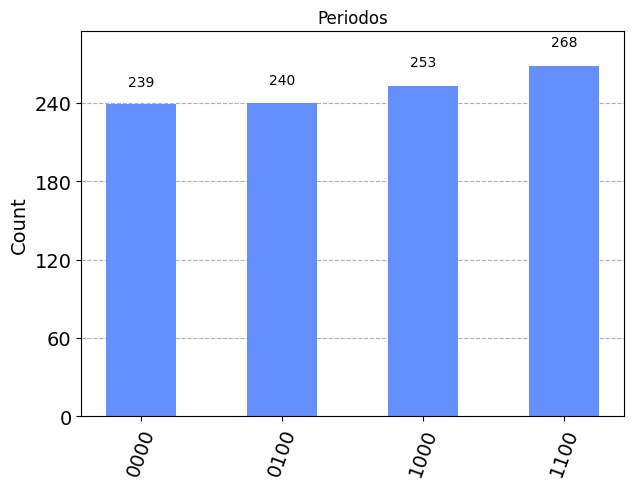

In [140]:
# Ejecutamos el circuito en un simulador cuántico
simulator = Aer.get_backend('aer_simulator', device = 'gpu')
find_period_transpiled = transpile(qc_periodo_potencia2), simulator)

# Run and get counts
result = simulator.run(find_period_transpiled, shots=1000).result()
counts = result.get_counts(find_period_transpiled)
plot_histogram(counts, title='Periodos')

In [24]:
def Shor_potencia2(n):
    M = 2**(math.ceil(math.log2(n)))
    for base in range(2,n):
        # Buscamos una base para la funcion periodica
        print("Base a probar =", base)
        # Si gcd(base,n) fuera mayor que 1, realmente ya habriamos factorizado el numero
        # Sin embargo, esto no nos interesa ahora, pues los ejemplos que tenemos son de laboratorio
        # y es un caso muy improbable con valores de n grandes
        if math.gcd(base, n) == 1:
            # Calculamos el periodo de la funcion
            # Ejecutamos el circuito en un simulador cuántico
            simulator = Aer.get_backend('aer_simulator', device = 'gpu')
            find_period_transpiled = transpile(busqueda_periodo_potencia2(15, base), simulator)
            
            # Run and get counts
            result = simulator.run(find_period_transpiled, shots=1000).result()
            counts = result.get_counts(find_period_transpiled)
            #print(result)
            
            for c in counts:
                res = int(c, 2)
                if res != 0:
                    posible_periodo = M // res # Convertimos el string en binario a int
                    if posible_periodo % 2 == 0:
                        posible_raiz = base**(posible_periodo//2) % n
                        print('Posible raiz:', posible_raiz)
                        if (posible_raiz*posible_raiz) % n == 1 and posible_raiz != 1 and posible_raiz != n - 1:
                            # Si encontramos una raiz, tenemos la factorizacion de n
                            p = math.gcd(posible_raiz - 1, n)
                            q = n // p
                            print('Factorizacion:', n, '=', p, "*", q)
                            return p, q

In [25]:
fact = Shor_potencia2(15)

Base a probar = 2
Result(backend_name='aer_simulator', backend_version='0.14.2', qobj_id='', job_id='c3826545-95ae-49a1-b6ae-337be86ac748', success=True, results=[ExperimentResult(shots=1000, success=True, meas_level=2, data=ExperimentResultData(counts={'0xc': 283, '0x8': 237, '0x0': 221, '0x4': 259}), header=QobjExperimentHeader(creg_sizes=[['c2', 4]], global_phase=0.0, memory_slots=4, n_qubits=26, name='Find_period', qreg_sizes=[['x', 4], ['mult', 4], ['aux', 18]], metadata={}), status=DONE, seed_simulator=3137389521, metadata={'batched_shots_optimization': False, 'required_memory_mb': 1024, 'method': 'statevector', 'active_input_qubits': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25], 'device': 'CPU', 'remapped_qubits': False, 'num_qubits': 26, 'num_clbits': 4, 'time_taken': 250.2898405, 'sample_measure_time': 0.0891828, 'input_qubit_map': [[0, 0], [1, 1], [2, 2], [3, 3], [4, 4], [5, 5], [6, 6], [7, 7], [8, 8], [9, 9], [10, 10], [11, 1

In [26]:
print(fact)

(5, 3)


<h3>Busqueda del periodo arbitrario</h3>

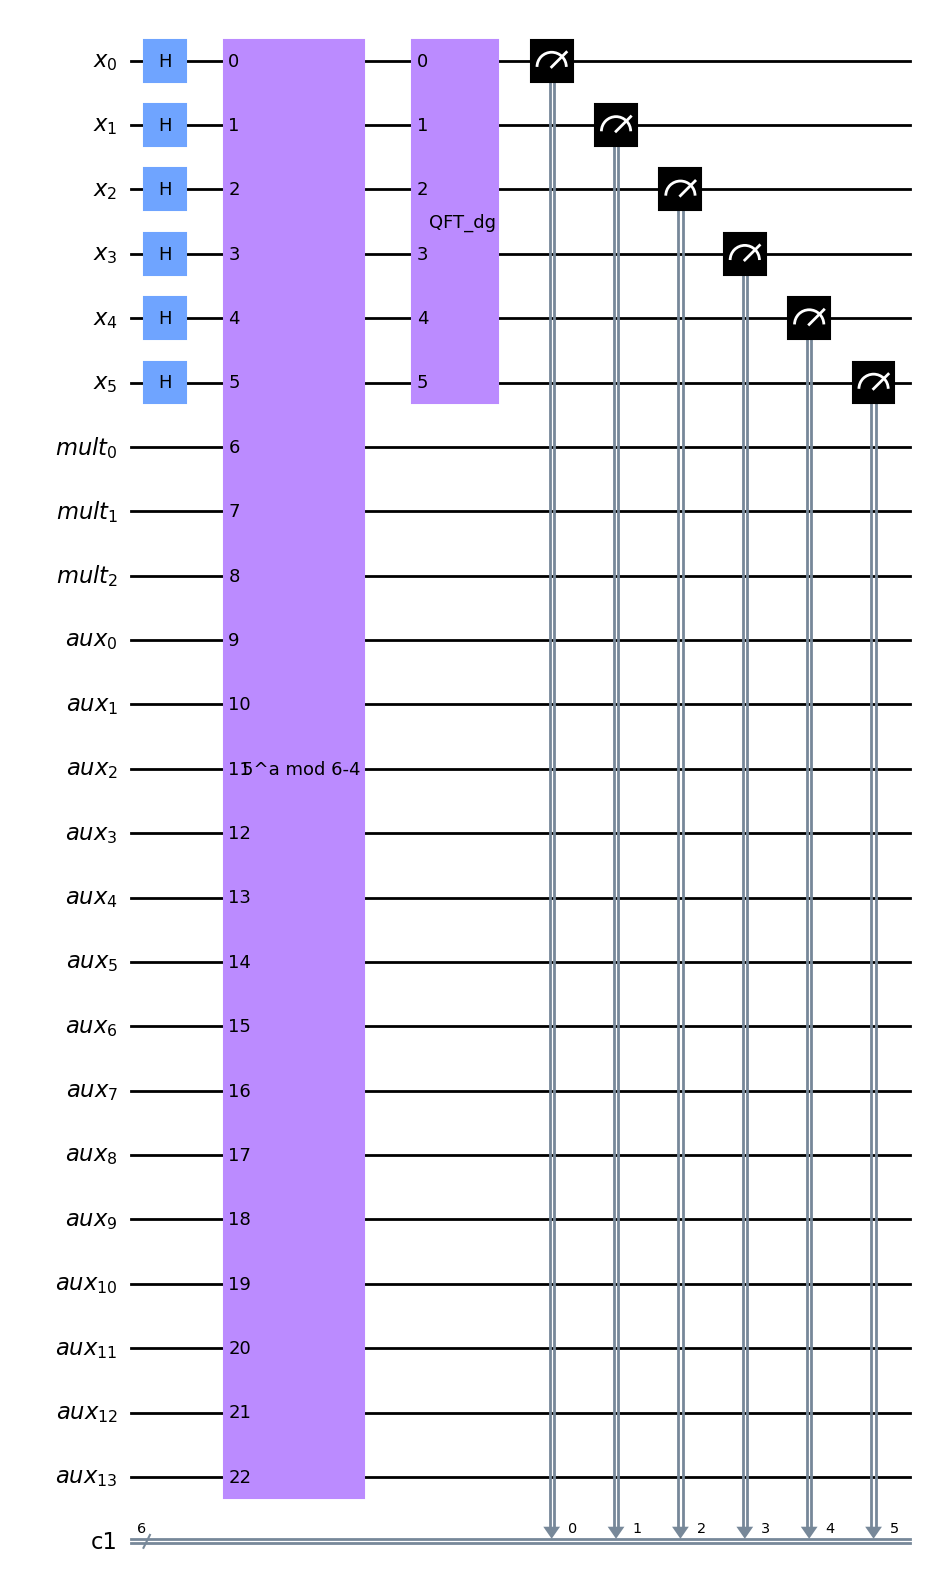

In [20]:
# Busqueda del periodo de una funcion
def busqueda_periodo(num, base):
    n_out = math.ceil(math.log2(num))
    n_in = 2*n_out
    
    qr_x = QuantumRegister(n_in,'x')
    qr_mult = QuantumRegister(n_out,'mult')
    qr_aux = QuantumRegister(4*n_out+2,'aux')
    cr = ClassicalRegister(n_in)
    find_period = QuantumCircuit(qr_x, qr_mult, qr_aux, cr, name = 'Find_period')
    
    # Superposicion de las entradas
    for i in range(n_in):
        find_period.h(i)
    
    # Aplicamos una funcion periodica
    funcion_periodica = createExpMod(n_in, n_out, base, num)
    funcion_periodica.draw('mpl')
    find_period.append(funcion_periodica, itertools.chain(range(n_in + 5*n_out+2)))   

    # Medimos el resultado de la funcion - Realmente no es necesario, los resultados seran los mismos
    #find_period.measure(range(n,2*n),range(n))
    #find_period.barrier()
    
    # Aplicamos la QFT a las entradas
    find_period.append(QFT(n_in).inverse(), range(n_in))
    
    # Medimos el resultado
    find_period.measure(range(n_in),range(n_in))
    return find_period
    
find_arb_period = busqueda_periodo(6,5)
find_arb_period.draw('mpl')

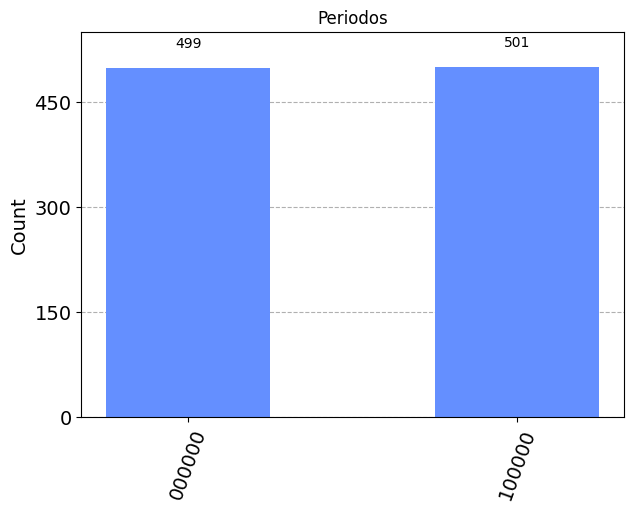

In [54]:
# Ejecutamos el circuito en un simulador cuántico
simulator = Aer.get_backend('aer_simulator', device = 'gpu')
find_arb_period_transpiled = transpile(find_arb_period, simulator)

# Run and get counts
result = simulator.run(find_arb_period_transpiled, shots=1000).result()
counts = result.get_counts(find_arb_period_transpiled)
# Agregar los estados con cuenta 0 al diccionario de counts
#for state in possible_states:
#    if state not in counts:
#        counts[state] = 0
plot_histogram(counts, title='Periodos')

In [55]:
print(counts)
counts_ordenado = dict(sorted(counts.items(), key=lambda item: item[1], reverse=True))
print(counts_ordenado)

{'100000': 501, '000000': 499}
{'100000': 501, '000000': 499}


In [31]:
def list_to_frac(l):
    expr = Integer(0)
    for i in reversed(l[1:]):
        expr += i
        expr = 1/expr
    return l[0] + expr

In [59]:
def Shor(n, factor_no_trivial = True):
    num_valores = 2**(2*math.ceil(math.log2(n)))
    print(num_valores)
    for base in range(2,n):
        # Buscamos una base para la funcion periodica
        print("Base a probar =", base)
        # Si gcd(base,n) fuera mayor que 1, realmente ya habriamos factorizado el numero
        # Sin embargo, esto no nos interesa ahora, pues los ejemplos que tenemos son de laboratorio
        # y es un caso muy improbable con valores de n grandes
        if math.gcd(base, n) == 1:
            # Calculamos el periodo de la funcion
            # Ejecutamos el circuito en un simulador cuántico
            simulator = Aer.get_backend('aer_simulator', device = 'gpu')
            find_period_transpiled = transpile(busqueda_periodo(n, base), simulator)
            result = simulator.run(find_period_transpiled, shots=1000).result()
            counts = result.get_counts(find_period_transpiled)
            # Ordenamos los resultados por frecuencia
            counts_ordenado = dict(sorted(counts.items(), key=lambda item: item[1], reverse=True))
            
            print('Resultados con base', base, ':', counts_ordenado)
            
            for key in counts_ordenado.keys():
                #fraccion = Rational(2**(ceil(log2(n))),posible_periodo)
                posible_periodo = int(key, 2) # Convertimos el string en binario a int
                print('Posible t*M/p:', posible_periodo)
                # Si la division es exacta, probamos la raiz resultante de p
                if posible_periodo != 0:
                    # Calculamos las convergentes de posible periodo / 2^{n_bits}
                    fraccion = Rational(posible_periodo,num_valores)
                    
                    print('Fraccion:', fraccion)
                    fraccion_continua = continued_fraction(fraccion)
                    print('fraccion_continua:', fraccion_continua)
                    
                    for i in range(len(fraccion_continua)):
                        a = list_to_frac(fraccion_continua[:i+1])
                        print('Convergente', i, ':', a)
                        posible_periodo = a.q
                        print('Posible periodo:', posible_periodo)
                        if posible_periodo % 2 == 0:
                            posible_raiz = base**(posible_periodo//2) % n
                            print('Posible raiz:', posible_raiz)
                            if (posible_raiz*posible_raiz) % n == 1 and ((not factor_no_trivial) or (posible_raiz != 1 and posible_raiz != n - 1)):
                                # Si encontramos una raiz, tenemos la factorizacion de n
                                p = math.gcd(posible_raiz - 1, n)
                                q = n // p
                                print('Factorizacion:', n, '=', p, "*", q)
                                return p, q

In [60]:
fact = Shor(6, False)

64
Base a probar = 2
Base a probar = 3
Base a probar = 4
Base a probar = 5
Resultados con base 5 : {'100000': 524, '000000': 476}
Posible t*M/p: 32
Fraccion: 1/2
fraccion_continua: [0, 2]
Convergente 0 : 0
Posible periodo: 1
Convergente 1 : 1/2
Posible periodo: 2
Posible raiz: 5
Factorizacion: 6 = 2 * 3


In [75]:
print(fact)

(2, 3)


### Ejemplo de búsqueda de periodo no potencia de 2

In [24]:
find_arb_period2 = busqueda_periodo(7,3)

F:\ProgramFiles\Anaconda\envs\quantum_computing\lib\site-packages\qiskit\visualization\circuit\matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


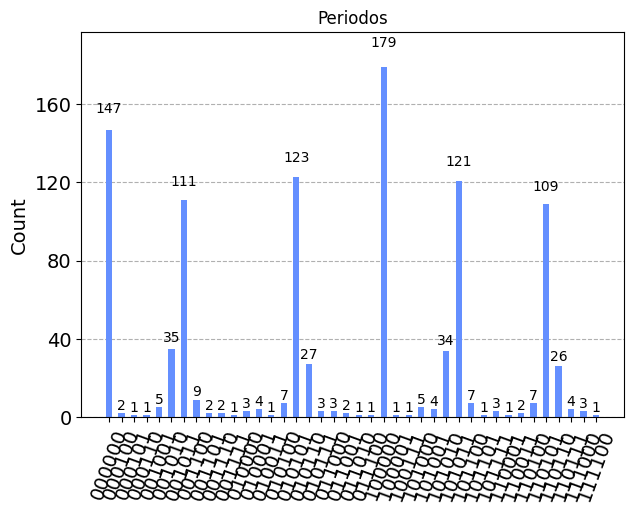

In [25]:
# Ejecutamos el circuito en un simulador cuántico
simulator = Aer.get_backend('aer_simulator', device = 'gpu')
find_arb_period2_transpiled = transpile(find_arb_period2, simulator)

# Run and get counts
result = simulator.run(find_arb_period2_transpiled, shots=1000).result()
counts = result.get_counts(find_arb_period2_transpiled)
# Agregar los estados con cuenta 0 al diccionario de counts
#for state in possible_states:
#    if state not in counts:
#        counts[state] = 0
plot_histogram(counts, title='Periodos')

In [26]:
print(result.time_taken)

32.00384449958801


# Eficiencia

In [40]:
def calcula_eficiencia_suma_media():
    res = []
    for i in range(2,10):  #Tamaño del circuito
        t_medio = 0
        puertas_medio = 0
        circuito = createAdder(i)
        for j in range(3):  # Numero de simulaciones
            # Definimos el circuito a medir
            qr_a2 = QuantumRegister(i)
            qr_b2 = QuantumRegister(i+1)
            qr_c2 = QuantumRegister(i)
            cr2 = ClassicalRegister(i+1)
            qc_adder = QuantumCircuit(qr_a2, qr_b2, qr_c2, cr2)
            for k in range(2*i):   # Aplica 0 o 1 sobre la entrada
                if random.randint(0,10) < 5:
                    qc_adder.x(k)
            qc_adder.append(circuito, range(3*i+1))
            
            # Ejecutamos el circuito en un simulador cuántico
            simulator = Aer.get_backend('aer_simulator', device = 'gpu')
            qc_transpiled = transpile(qc_adder, simulator)
            result = simulator.run(qc_transpiled, shots=1000).result()
            t_medio += result.time_taken
            puertas_medio += count_gates(qc_transpiled.decompose().decompose().decompose())

        res.append((t_medio/3, puertas_medio/3))

    return res

In [39]:
res_suma = calcula_eficiencia_suma_media()
print(res_suma)

[(0.0010073184967041016, 100.66666666666667), (0.000997622807820638, 164.66666666666666), (0.0009978612263997395, 231.0), (0.001006762186686198, 293.3333333333333), (0.0009975433349609375, 358.6666666666667), (0.0013298988342285156, 424.0), (0.0013295809427897136, 489.0), (0.001680930455525716, 556.6666666666666)]


In [45]:
def calcula_eficiencia_suma_mod_media():
    res = []
    for i in range(2,7):  #Tamaño del circuito
        t_medio = 0
        puertas_medio = 0
        M = random.randint(2,2**i)
        circuito = createModAdderVedral(i,M)
        for j in range(3):  # Numero de simulaciones
            # Definimos el circuito a medir
            qr2 = QuantumRegister(4*i+2)
            cr2 = ClassicalRegister(i+1)
            qc_adder_mod = QuantumCircuit(qr2, cr2)
            for k in range(2*i):   # Aplica 0 o 1 sobre la entrada
                if random.randint(0,10) < 5:
                    qc_adder_mod.x(k)
            qc_adder_mod.append(circuito, range(4*i+2))
            
            # Ejecutamos el circuito en un simulador cuántico
            simulator = Aer.get_backend('aer_simulator', device = 'gpu')
            qc_transpiled = transpile(qc_adder_mod, simulator)
            result = simulator.run(qc_transpiled, shots=1000).result()
            t_medio += result.time_taken
            puertas_medio += count_gates(qc_transpiled.decompose().decompose().decompose().decompose())
        res.append((t_medio/3, puertas_medio/3))

    return res

In [46]:
res_suma_mod = calcula_eficiencia_suma_mod_media()
print(res_suma_mod)

[(0.0020024776458740234, 489.0), (0.002991914749145508, 814.0), (0.0029919942220052085, 1137.6666666666667), (0.0036469300587972007, 1463.0), (0.004967451095581055, 1775.3333333333333)]


In [47]:
def calcula_eficiencia_mul_mod_media():
    res = []
    for i in range(2,6):  #Tamaño del circuito
        t_medio = 0
        puertas_medio = 0
        M = random.randint(2,2**i)
        y = random.randint(2,2**i)
        circuito = createMult(i, y, M)
        for j in range(3):  # Numero de simulaciones
            # Definimos el circuito a medir
            qr2 = QuantumRegister(5*i+3)
            cr2 = ClassicalRegister(i)
            qc_mul_mod = QuantumCircuit(qr2, cr2)
            qc_mul_mod.x(0)
            for k in range(1,i+1):   # Aplica 0 o 1 sobre la entrada
                if random.randint(0,10) < 5:
                    qc_mul_mod.x(k)
            qc_mul_mod.append(circuito, range(5*i+3))
            # Ejecutamos el circuito en un simulador cuántico
            simulator = Aer.get_backend('aer_simulator', device = 'gpu')
            qc_transpiled = transpile(qc_mul_mod, simulator)
            result = simulator.run(qc_transpiled, shots=1000).result()
            t_medio += result.time_taken
            puertas_medio += count_gates(qc_transpiled.decompose().decompose().decompose().decompose().decompose().decompose())
        res.append((t_medio/3, puertas_medio/3))

    return res

In [48]:
res_mult_mod = calcula_eficiencia_mul_mod_media()
print(res_mult_mod)

[(0.002991914749145508, 1078.6666666666667), (0.006337563196818034, 2503.0), (0.01063863436381022, 4743.333333333333), (0.017365217208862305, 7580.333333333333)]


In [52]:
def calcula_eficiencia_exp_mod_media():
    res = []
    for i in range(2,5):  #Tamaño del circuito
        t_medio = 0
        puertas_medio = 0
        M = random.randint(2,2**i)
        y = random.choice(list(sympy.primerange(3, 2**i)))
        while math.gcd(M, y)  != 1:
            M = random.randint(2,2**i)
        circuito = createExpMod(i, i, y, M)
        for j in range(3):  # Numero de simulaciones
            # Definimos el circuito a medir
            qr2 = QuantumRegister(6*i+2)
            cr2 = ClassicalRegister(i)
            qc_mul_mod = QuantumCircuit(qr2, cr2)
            for k in range(1,i+1):   # Aplica 0 o 1 sobre la entrada
                if random.randint(i,10) < 5:
                    qc_mul_mod.x(k)
            qc_mul_mod.append(circuito, range(6*i+2))
            # Ejecutamos el circuito en un simulador cuántico
            simulator = Aer.get_backend('aer_simulator', device = 'gpu')
            qc_transpiled = transpile(qc_mul_mod, simulator)
            result = simulator.run(qc_transpiled, shots=1000).result()
            t_medio += result.time_taken
            puertas_medio += count_gates(qc_transpiled.decompose().decompose().decompose().decompose().decompose().decompose().decompose())
        res.append((t_medio/3, puertas_medio/3))

    return res

In [53]:
res_exp_mod = calcula_eficiencia_exp_mod_media()
print(res_exp_mod)

[(0.010294675827026367, 4297.666666666667), (0.03956143061319987, 15460.666666666666), (0.09276199340820312, 38833.0)]


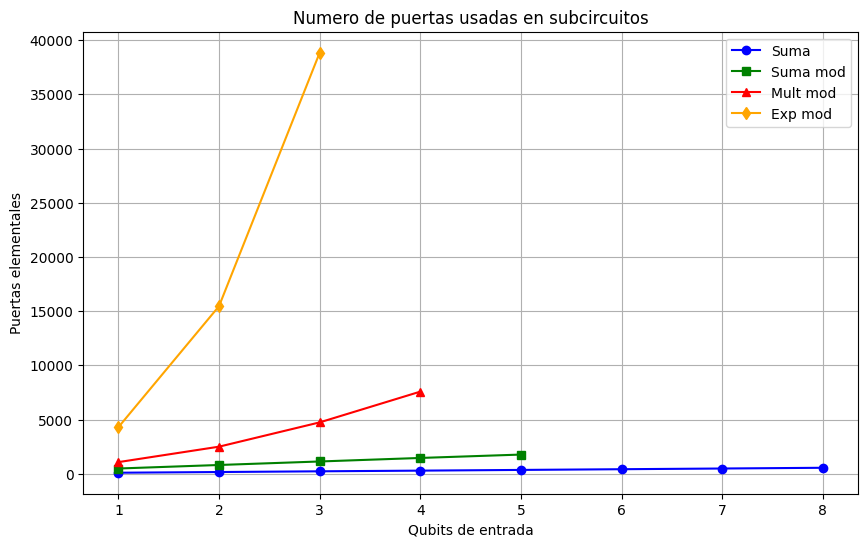

In [54]:
# Datos para las cuatro líneas
x = range(1, 11)
y1 = [y for x,y in res_suma]
y2 = [y for x,y in res_suma_mod]
y3 = [y for x,y in res_mult_mod]
y4 = [y for x,y in res_exp_mod]

# Crear la figura y los ejes
plt.figure(figsize=(10, 6))

# Agregar las líneas
plt.plot(x[:len(y1)], y1, label='Suma', color='blue', marker='o')
plt.plot(x[:len(y2)], y2, label='Suma mod', color='green', marker='s')
plt.plot(x[:len(y3)], y3, label='Mult mod', color='red', marker='^')
plt.plot(x[:len(y4)], y4, label='Exp mod', color='orange', marker='d')

# Agregar títulos y etiquetas
plt.title('Numero de puertas usadas en subcircuitos')
plt.xlabel('Qubits de entrada')
plt.ylabel('Puertas elementales')

# Agregar una leyenda
plt.legend()

# Mostrar la gráfica
plt.grid(True)
plt.show()


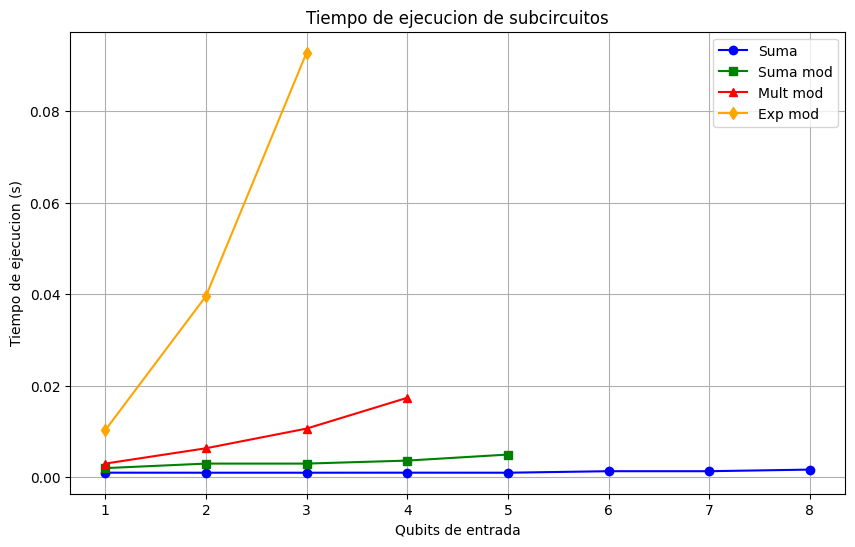

In [55]:
# Datos para las cuatro líneas
x = range(1, 11)
y1 = [x for x,y in res_suma]
y2 = [x for x,y in res_suma_mod]
y3 = [x for x,y in res_mult_mod]
y4 = [x for x,y in res_exp_mod]

# Crear la figura y los ejes
plt.figure(figsize=(10, 6))

# Agregar las líneas
plt.plot(x[:len(y1)], y1, label='Suma', color='blue', marker='o')
plt.plot(x[:len(y2)], y2, label='Suma mod', color='green', marker='s')
plt.plot(x[:len(y3)], y3, label='Mult mod', color='red', marker='^')
plt.plot(x[:len(y4)], y4, label='Exp mod', color='orange', marker='d')

# Agregar títulos y etiquetas
plt.title('Tiempo de ejecucion de subcircuitos')
plt.xlabel('Qubits de entrada')
plt.ylabel('Tiempo de ejecucion (s)')

# Agregar una leyenda
plt.legend()

# Mostrar la gráfica
plt.grid(True)
plt.show()

## Ejecución en un ordenador cuántico real

Pruebas con circuitos pequeños

In [247]:
# Ejecucion en ordenador cuantico real
from qiskit import IBMQ
from qiskit import QuantumCircuit, transpile, assemble, execute
from qiskit.tools.monitor import job_monitor

In [30]:
# Prueba del sumador de 2 qubits
n = 2
qr_a = QuantumRegister(n,'a')
qr_b = QuantumRegister(n+1,'b')
qr_c = QuantumRegister(n,'c')
cr = ClassicalRegister(n+1, 'suma')
qc_suma_2 = QuantumCircuit(qr_a, qr_b, qr_c,cr)
# A = 01 = 1
qc_suma_2.x(0)
# B = 11 = 3
qc_suma_2.x(n)
qc_suma_2.x(n+1)

qc_suma_2.append(createAdder(n), range(3*n+1))
for i in range(n+1):
    qc_suma_2.measure(n+i,i)
# Resultado esperado = A + B = 3 + 1 = 4 = 100
qc_suma_2.draw('mpl')
print(count_gates(qc_suma_2.decompose().decompose().decompose()))

104


In [32]:
# Iniciamos sesión
IBMQ.save_account('f2976d6b0d807e2efcb3e34c8268e3198096464b28700cb487e97796ec74ff7bf9cc259833f839f57a95e0842cb763b423e9b678585740cea13247df189b6913')
IBMQ.load_account()

configrc.store_credentials:WARNING:2024-06-21 10:51:17,769: Credentials already present. Set overwrite=True to overwrite.


<AccountProvider for IBMQ(hub='ibm-q', group='open', project='main')>

In [35]:
# Indicamos el dispositivo a usar
provider = IBMQ.get_provider(hub='ibm-q')
backend = provider.get_backend('ibm_osaka') 

# Transpilamos el circuito para el backend seleccionado
transpiled_qc = transpile(qc_suma_2, backend)
print('Puertas tras transpilar:', count_gates(transpiled_qc))

436


In [ ]:
# Crear el objeto de trabajo (job) y ejecutarlo
job = execute(transpiled_qc, backend, shots=100)

# Monitorear el trabajo
job_monitor(job)

# Obtener los resultados
result = job.result()

Job Status: job is queued (None)

In [ ]:
counts = result.get_counts(transpiled_qc)

plot_histogram(counts, title='Resultados 3+1')